In [ ]:
 import torch
 import torch.nn as nn
 import torchvision.transforms as transforms
 import torch.optim as optim
 import torchvision

 from PIL import Image
 from matplotlib import pyplot as plt

 device = "cuda" if torch.cuda.is_available() else 'cpu'
 print(device)

cuda


In [ ]:
vgg_model = torchvision.models.vgg19(weights = 'DEFAULT').features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.0MB/s]


In [ ]:
vgg_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


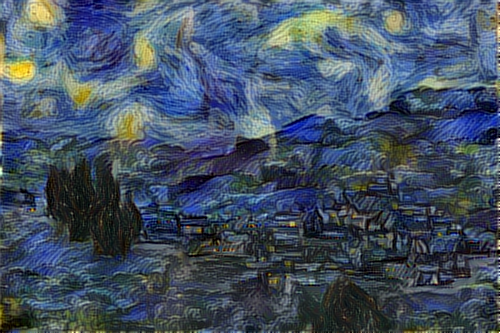

In [ ]:
style_image = Image.open('/content/drive/MyDrive/Colab Notebooks/images/Data/van gogh.png')
style_image

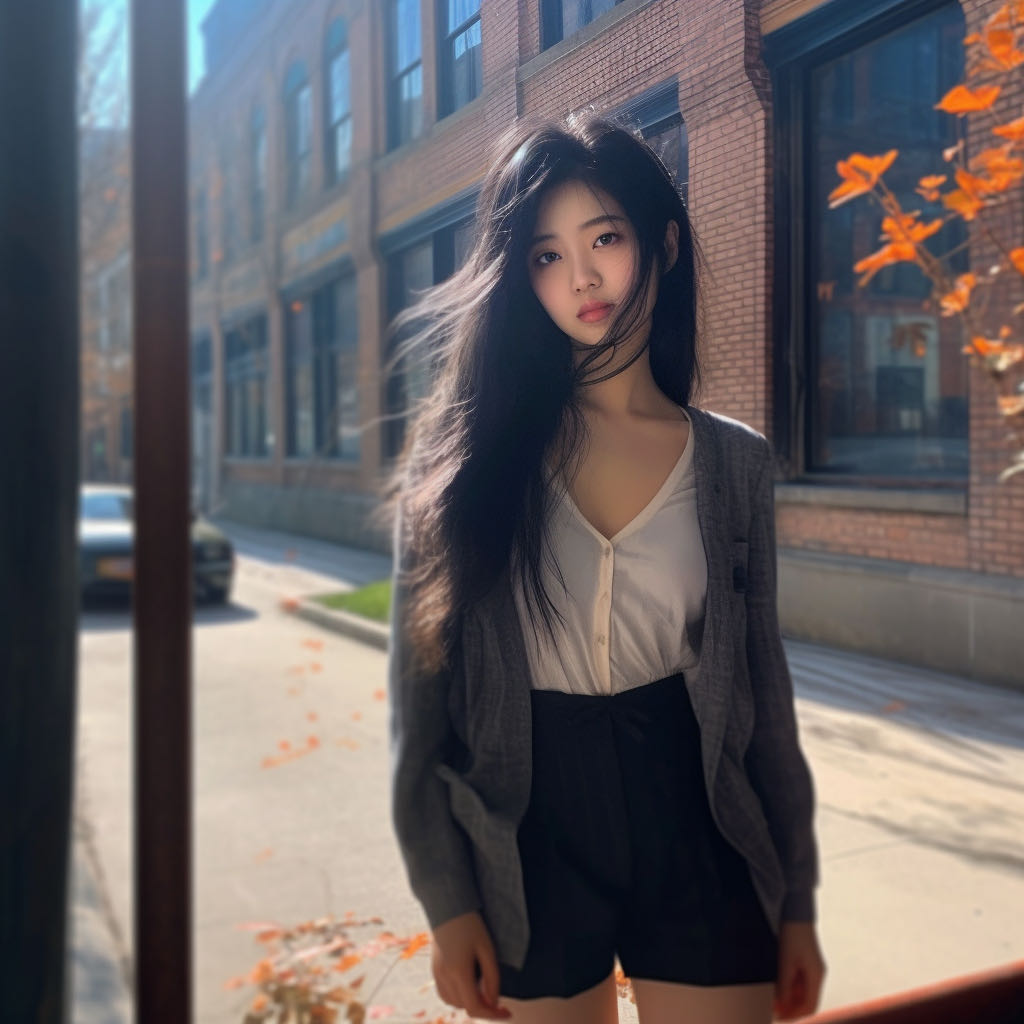

In [ ]:
content_image = Image.open('/content/drive/MyDrive/Colab Notebooks/images/Data/content.jpeg')
content_image

In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])

def prepocessing(img, image_shape = (224,224) , device = device):
  transforms = torchvision.transforms.Compose([
      torchvision.transforms.Resize(image_shape),
      torchvision.transforms.ToTensor(),  # (3, 224, 224)
      torchvision.transforms.Normalize(mean = mean , std = std)
  ])

  return transforms(img).unsqueeze(0).to(device) # (1,3,224,224)

In [ ]:
content_img = prepocessing(content_image)
print(content_img.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
style_img = prepocessing(style_image)
print(style_img.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
generated_img = content_img.clone().requires_grad_(True)
print(generated_img.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
class NST_VGG(nn.Module):
  def __init__(self):
    super(NST_VGG, self).__init__()

    self.styles_layers = [0, 5, 10, 19, 28]
    self.content_layers = [30]

    self.model = vgg_model

  def forward(self, x):
    contents = []
    styles = []

    for layer_num, layer in enumerate(self.model):
      x = layer(x)
      if layer_num in self.styles_layers:
        styles.append(x)

      if layer_num in self.content_layers:
        contents.append(x)

    return contents, styles

In [ ]:
def content_loss(content, generated):
  return torch.square( content.detach() - generated ).mean()


def gram(img):
  # image shape: (batchsize, channel, height, width)

  batch_size, channel, height, width = img.shape

  img = img.reshape( (batch_size * channel), height * width) # img shape: ( batchsize * channel, height * weight)

  return torch.matmul(img, img.T) / (batch_size * channel * height * width)

def style_loss(style, generated):
  A = gram(style).detach()
  B = gram(generated)

  return torch.square( A - B).mean()

def total_variation_loss(img):
  a = torch.abs(img[:,:, 1:, :] - img[:,:,:-1, :]).mean()
  b = torch.abs(img[:,:, :, 1:] - img[:,:,:, :-1]).mean()

  return (a + b ) / 2


In [ ]:
### total loss

def total_loss(content_y_hat, style_y_hat, content_y, style_y, generated_img):

  ### content_y_hat: [features_map1] # 这个feature map只有1个是[30]
  ### content_y.   : [features_map1]
  ### style_y_hat:   [features_map1, feature_map2, ... feature_map5] # 这个feature map有5个[0, 5, 10, 19, 28]
  ## feature_map1: [(1, 3, 256, 256), ... ,]
  ### style_y:       [features_map1, feature_map2, ... feature_map5]

  # alpha = 1000
  # beta = 0.001

  alpha = 1000
  beta  = 0.01
  theta = 0.1

  style_l =sum([style_loss(x, y) for (x,y) in zip(style_y, style_y_hat)])
  content_l  = sum([content_loss(x, y) for (x, y) in zip(content_y, content_y_hat)])
  tv_l  =  total_variation_loss(generated_img)

  total = style_l * alpha + content_l * beta + tv_l * theta

  return style_l * alpha, content_l * beta, tv_l * theta, total # add tv_l * theta





In [ ]:
def train(
    genereted_img,
    content_img  ,
    style_img,
    model,
    lr = 0.1,
    num_epochs = 5000,
    lr_decay_epoch = 50
):
  optimizer = torch.optim.Adam([generated_img], lr = lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, 0.8)

  content_y, _ = model(content_img)
  _, style_y   = model(style_img)

  cl_list = []
  sl_list = []
  # add one list for total variation
  tvl_list = []
  total_list = []

  for epoch in range(num_epochs):
    optimizer.zero_grad()

    content_y_hat, style_y_hat = model(genereted_img) # pred y [ content, style ]. ## output = model(image)

    sl , cl , tvl, tl = total_loss(content_y_hat, style_y_hat, content_y, style_y, genereted_img) # [revise]

    sl_list.append(sl)
    cl_list.append(cl)
    ## add
    tvl_list.append(tvl)
    ##
    total_list.append(tl)


    tl.backward()
    optimizer.step() # generated_img = generated_img - lr * grad(generated_img)
    scheduler.step()

  return generated_img, cl_list, sl_list, tvl_list, total_list

In [ ]:
model = NST_VGG().to(device).eval()

In [ ]:
generated_img, cl_list, sl_list, tvl_list, total_list = train(generated_img,
                                                              content_img ,
                                                              style_img,
                                                              model,
                                                              lr = 0.1,
                                                              num_epochs=500,
                                                              lr_decay_epoch=50)

In [ ]:
img = generated_img[0].to('cpu')
img = torch.clamp(img.permute(1,2,0) * std + mean , 0, 1)

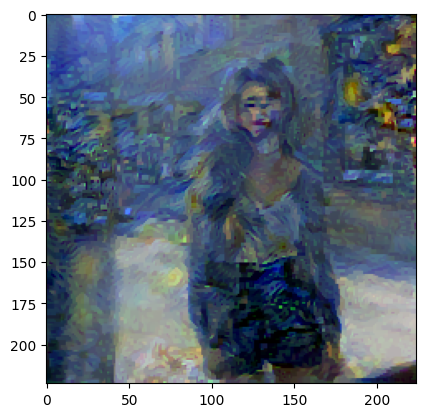

In [ ]:
plt.imshow( img.detach().numpy() )

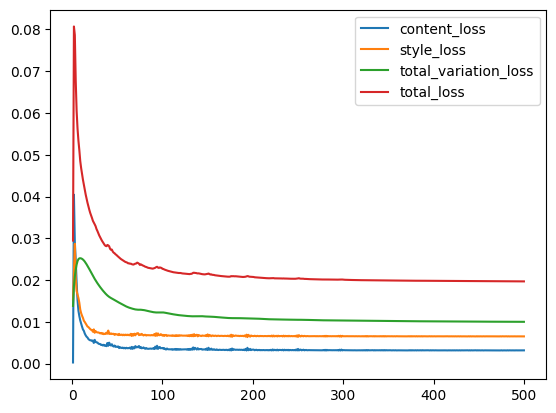

In [ ]:
plt.plot( list(range(1,501)), [i.item() for i in cl_list], label = 'content_loss')
plt.plot( list(range(1,501)), [i.item() for i in sl_list], label = 'style_loss')
plt.plot( list(range(1,501)), [i.item() for i in tvl_list], label = 'total_variation_loss')
plt.plot( list(range(1,501)), [i.item() for i in total_list], label = 'total_loss')
plt.legend()
plt.show()
# 为什么一开始loss会同时上升？

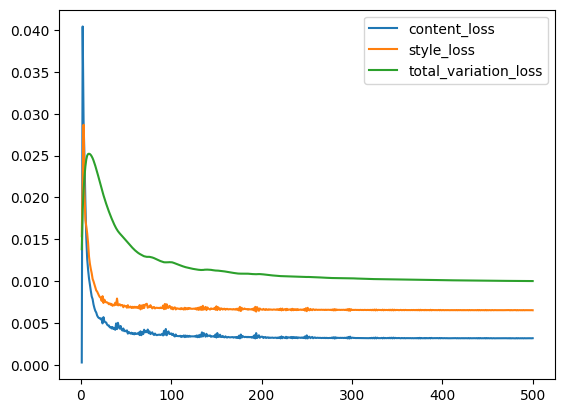

In [ ]:
plt.plot( list(range(1,501)), [i.item() for i in cl_list], label = 'content_loss')
plt.plot( list(range(1,501)), [i.item() for i in sl_list], label = 'style_loss')
plt.plot( list(range(1,501)), [i.item() for i in tvl_list], label = 'total_variation_loss')
plt.legend()
plt.show()